In [1]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os

pd.set_option('display.max_rows', None)  # Mostrar todas las filas
pd.set_option('display.max_columns', None)  # Mostrar todas las columnas
pd.set_option('display.expand_frame_repr', False)  # Evitar cortar en varias líneas
pd.set_option('display.max_colwidth', None)  # Evitar cortar el contenido de las celdas

df = pd.read_csv('dataset_final.csv')

**Cargar datos**

In [ ]:
# 1. Columnas
columnas_numericas = ['Age', 'CK-MB_log', 'Troponin_log']
columna_objetivo = 'Result'

# 2. Separar X (predictoras) e y (objetivo)
X = df[columnas_numericas]
y = df[columna_objetivo]

# 3. Separar en train y test antes de escalar
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# 4. Escalar solo las columnas numéricas del train
scaler = StandardScaler()
X_train_num_scaled = scaler.fit_transform(X_train[columnas_numericas])
X_test_num_scaled = scaler.transform(X_test[columnas_numericas])

# guardar scaler
joblib.dump(scaler, 'modelos/scaler.pkl')


# 5. Convertir a DataFrames con nombres de columnas
X_train_final = pd.DataFrame(X_train_num_scaled, columns=columnas_numericas, index=X_train.index)
X_test_final = pd.DataFrame(X_test_num_scaled, columns=columnas_numericas, index=X_test.index)

# Verificación opcional
print(X_train_final.head())
print(y_train.head())

           Age  CK-MB_log  Troponin_log
881  -0.159143   0.938751     -0.815166
723  -1.467989   0.096629     -1.053250
889   0.640708  -0.677957      1.316036
1004  1.149703  -0.968734     -0.273049
761  -0.086429  -0.804186      0.552234
881     1
723     0
889     1
1004    1
761     1
Name: Result, dtype: int64


**Cargar modelos**

In [3]:
import joblib
import os
from sklearn.metrics import accuracy_score

# Definir los nombres de los modelos y los archivos correspondientes
nombres_modelos = ['log', 'nb', 'knn', 'arbol', 'svm']
modelos = {}
predicciones = {}
accuracies = {}

# Cargar los modelos y predecir
for nombre in nombres_modelos:
    ruta = os.path.join('modelos', f'modelo_{nombre}.pkl')
    modelo = joblib.load(ruta)
    modelos[nombre] = modelo
    pred = modelo.predict(X_test_final)
    predicciones[nombre] = pred
    accuracies[nombre] = accuracy_score(y_test, pred)

# Si querés imprimir los resultados
for nombre, acc in accuracies.items():
    print(f'Accuracy del modelo {nombre}: {acc:.4f}')


Accuracy del modelo log: 0.9318
Accuracy del modelo nb: 0.9356
Accuracy del modelo knn: 0.9470
Accuracy del modelo arbol: 0.9735
Accuracy del modelo svm: 0.9470


In [4]:
import joblib
import os
from sklearn.model_selection import cross_val_score

# Definir nombres y ruta de modelos
carpeta_modelos = 'modelos'

# Diccionario para guardar modelos cargados
modelos_cv = {}

# Cargar los modelos desde archivos .pkl
for nombre in nombres_modelos:
    ruta = os.path.join(carpeta_modelos, f'modelo_{nombre}.pkl')
    modelo = joblib.load(ruta)
    modelos_cv[nombre] = modelo

# Métricas a evaluar con cross-validation
scoring = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
resultados_cv = {}

# Evaluar cada modelo con cross-validation
for nombre, modelo in modelos_cv.items():
    print(f"\nModelo: {nombre.upper()}")
    resultados_cv[nombre] = {}
    for metrica in scoring:
        try:
            scores = cross_val_score(modelo, X_train, y_train, cv=10, scoring=metrica)
            media = round(scores.mean(), 4)
            resultados_cv[nombre][metrica] = media
            print(f"  {metrica.capitalize():<10}: {media}")
        except Exception as e:
            resultados_cv[nombre][metrica] = f"No disponible ({e})"
            print(f"  {metrica.capitalize():<10}: No disponible ({e})")




Modelo: LOG
  Accuracy  : 0.909
  Precision : 0.9326
  Recall    : 0.9181
  F1        : 0.925
  Roc_auc   : 0.9689

Modelo: NB
  Accuracy  : 0.9337
  Precision : 0.9771
  Recall    : 0.9137
  F1        : 0.944
  Roc_auc   : 0.9833

Modelo: KNN
  Accuracy  : 0.9185
  Precision : 0.9582
  Recall    : 0.9073
  F1        : 0.9316
  Roc_auc   : 0.9688

Modelo: ARBOL
  Accuracy  : 0.9811
  Precision : 0.9864
  Recall    : 0.9831
  F1        : 0.9846
  Roc_auc   : 0.9805

Modelo: SVM
  Accuracy  : 0.7962
  Precision : 0.8137
  Recall    : 0.8688
  F1        : 0.8395
  Roc_auc   : 0.8859


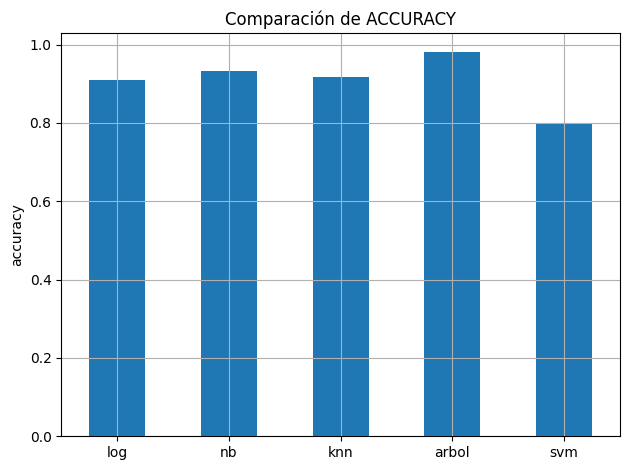

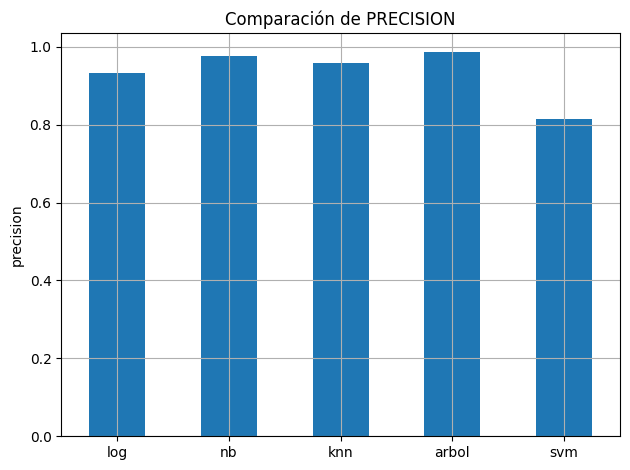

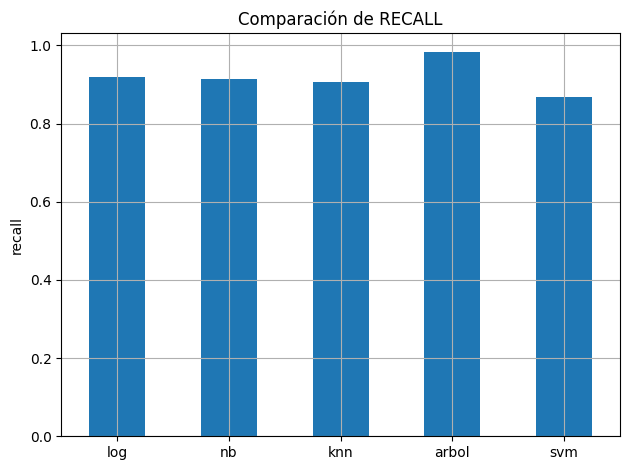

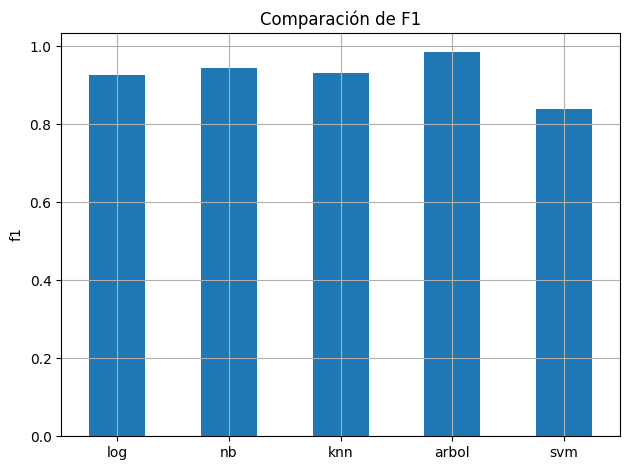

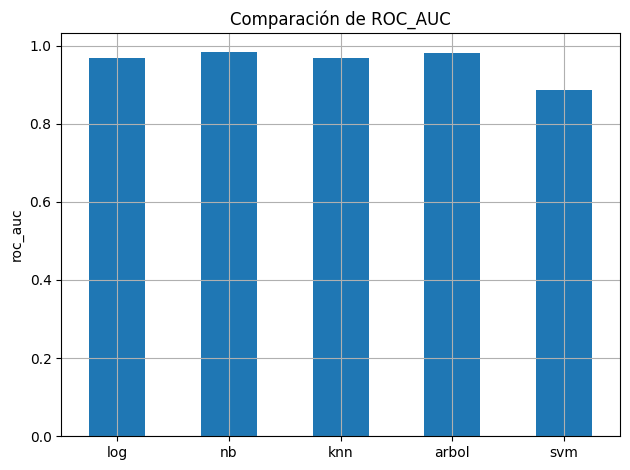

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

# Convertir resultados_cv a DataFrame
df_metricas = pd.DataFrame(resultados_cv).T  # Transponer para tener modelos como filas

# Graficar cada métrica
for metrica in df_metricas.columns:
    df_metricas[metrica].dropna().plot(kind='bar', title=f'Comparación de {metrica.upper()}', ylabel=metrica)
    plt.xticks(rotation=0)
    plt.grid(True)
    plt.tight_layout()
    plt.show()


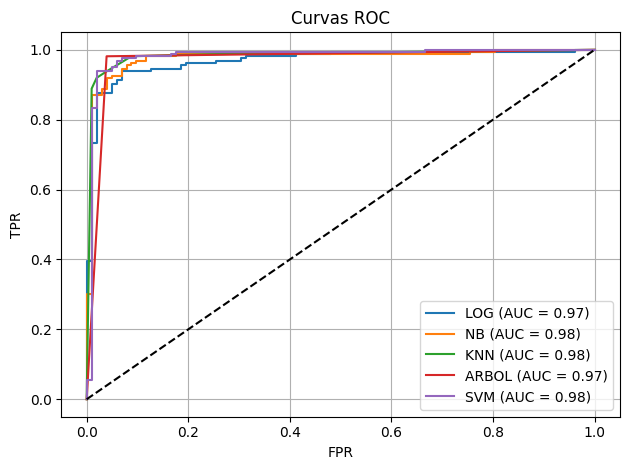

In [6]:
from sklearn.metrics import roc_curve, auc

plt.figure()

for nombre, modelo in modelos_cv.items():
    try:
        y_prob = modelo.predict_proba(X_test_final)[:, 1]  # Probabilidad clase positiva
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        auc_score = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{nombre.upper()} (AUC = {auc_score:.2f})')
    except Exception as e:
        print(f"No se pudo calcular ROC para {nombre}: {e}")

plt.plot([0, 1], [0, 1], 'k--')  # línea base
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('Curvas ROC')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


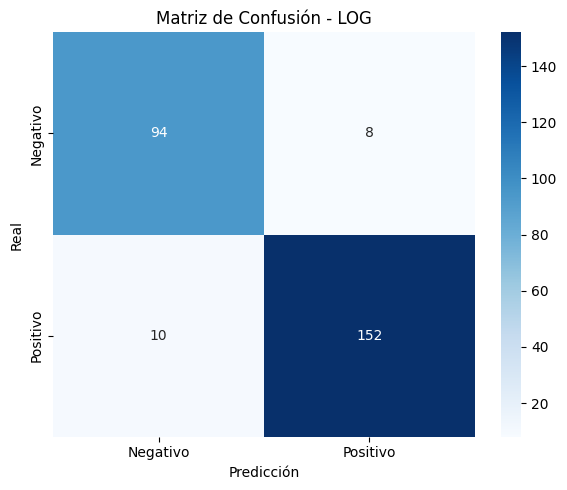

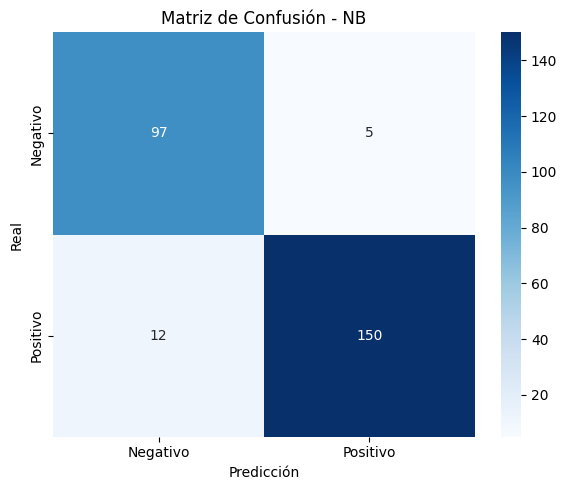

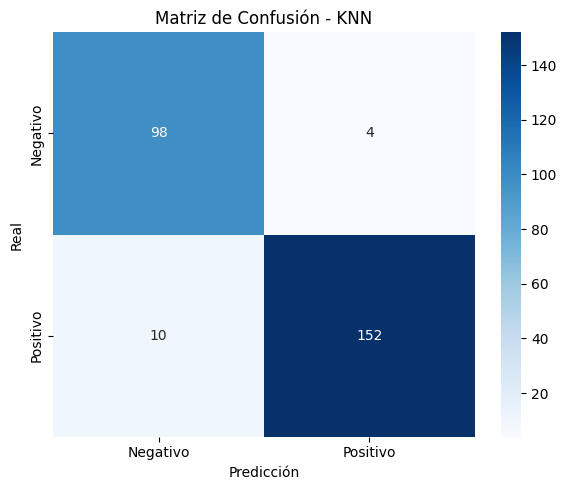

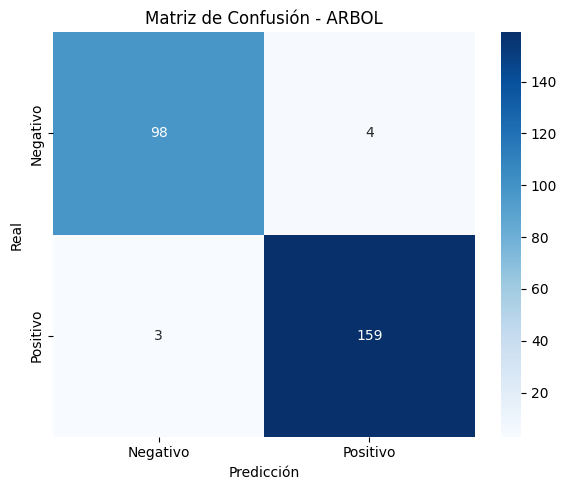

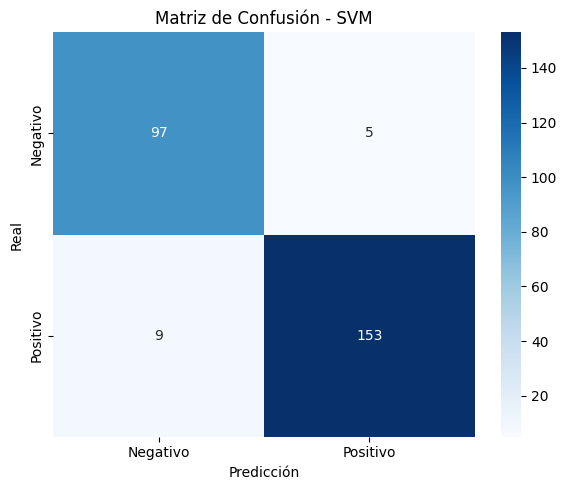

In [9]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Etiquetas personalizadas para los ejes
etiquetas = ["Negativo", "Positivo"]

for nombre, modelo in modelos_cv.items():
    y_pred = modelo.predict(X_test_final)
    cm = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues',
                xticklabels=etiquetas, yticklabels=etiquetas)
    plt.title(f'Matriz de Confusión - {nombre.upper()}')
    plt.xlabel("Predicción")
    plt.ylabel("Real")
    plt.tight_layout()
    plt.show()


**WEB**

In [15]:
print(df.head())

   Age  CK-MB_log  Troponin_log  Result
0   64   0.587787     -4.422849       0
1   21   1.909543      0.058269       1
2   55   0.688135     -5.809143       0
3   64   2.629728     -2.103734       1
4   55   0.076961     -5.809143       0


import pandas as pd
import matplotlib.pyplot as plt

# Convertir resultados_cv a DataFrame
df_metricas = pd.DataFrame(resultados_cv).T  # Transponer para tener modelos como filas

# Graficar cada métrica
for metrica in df_metricas.columns:
    df_metricas[metrica].dropna().plot(kind='bar', title=f'Comparación de {metrica.upper()}', ylabel=metrica)
    plt.xticks(rotation=0)
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [7]:
for nombre, modelo in modelos.items():
    print(f"\nModelo: {nombre}")

    # Intentar extraer coeficientes e intercepto (modelos lineales)
    if hasattr(modelo, 'coef_'):
        print("  Coeficientes (coef_):", modelo.coef_)
    else:
        print("  Coeficientes no disponibles para este modelo.")

    if hasattr(modelo, 'intercept_'):
        print("  Intercepto (intercept_):", modelo.intercept_)
    else:
        print("  Intercepto no disponible para este modelo.")

    # Si el modelo tiene feature_importances_ (árboles, random forest, etc.)
    if hasattr(modelo, 'feature_importances_'):
        print("  Importancia de características (feature_importances_):", modelo.feature_importances_)

    # Si es un modelo Naive Bayes (GaussianNB, MultinomialNB)
    if hasattr(modelo, 'class_log_prior_'):
        print("  Log de prob. a priori (class_log_prior_):", modelo.class_log_prior_)

    if hasattr(modelo, 'feature_log_prob_'):
        print("  Log de prob. por feature y clase (feature_log_prob_):", modelo.feature_log_prob_)

    if hasattr(modelo, 'theta_'):
        print("  Media por clase y feature (theta_):", modelo.theta_)

    if hasattr(modelo, 'sigma_'):
        print("  Varianza por clase y feature (sigma_):", modelo.sigma_)

    # Si es un KNN
    if hasattr(modelo, 'n_neighbors'):
        print(f"  Número de vecinos (n_neighbors): {modelo.n_neighbors}")



Modelo: log
  Coeficientes (coef_): [[-0.15100729  2.39920378  5.29366573]]
  Intercepto (intercept_): [2.80690797]

Modelo: nb
  Coeficientes no disponibles para este modelo.
  Intercepto no disponible para este modelo.
  Media por clase y feature (theta_): [[-0.30242653 -0.4139268  -0.75206835]
 [ 0.18995     0.2599818   0.47236392]]

Modelo: knn
  Coeficientes no disponibles para este modelo.
  Intercepto no disponible para este modelo.
  Número de vecinos (n_neighbors): 5

Modelo: arbol
  Coeficientes no disponibles para este modelo.
  Intercepto no disponible para este modelo.
  Importancia de características (feature_importances_): [0.00825477 0.37703141 0.61471382]

Modelo: svm
  Coeficientes no disponibles para este modelo.
  Intercepto (intercept_): [0.99529974]
